# ML voor gestructureerde data

In dit onderdeel bekijken we de machine learning concepten in de context van gestructureerde data. Gestructureerde data is data die een gestandaardiseerd formaat heeft dat wordt gedefinieerd door een schema. Deze data wordt doorgaans opgeslagen in een tabelformaat met rijen en kolommen, wat het gemakkelijk maakt om te doorzoeken en te analyseren.

:::{important} Eigenschappen
- **Veel en heterogene inputvariabelen**: Niet alle variabelen zijn belangrijk voor de taak. Om met zo min mogelijk features te eindigen, is **feature selectie** nodig.
- **Complexe, niet-lineaire verbanden tussen inputvariabelen en targets**
- **{ref}`Ongebalanceerdheid <target-imbalance>`**
- **Grote (big) datavolumes**
- **Aantrekkelijk voor geautomatiseerde ML (AutoML)**
  Ter illustratie:
    - [auto-sklearn](https://automl.github.io/auto-sklearn/master/)
    - [TPOT](https://epistasislab.github.io/tpot/latest/)
    - [Ludwig](https://ludwig.ai/latest/user_guide/automl/)
    - [AutoGluon](https://auto.gluon.ai/stable/index.html)
    - ...
- **Meestal op basis van _ensembles_ van _decision tree_ modellen**
:::

## _Decision Tree_ modellen
Patroonherkenning in gestructureerde (en in bepaalde gevallen ook semi-gestructureerde) data is vaak zeer succesvol met zogenaamde **_decision tree_** modellen en voornamelijk de **_ensemble learning_** varianten hiervan (zie {ref}`random forests <target-random-forests>` en {ref}`gradient boosted trees <target-boosting>` verder in deze sectie).

(target-decision-tree)=
**Een _decision tree_ model bestaat uit een boomstructuur waarbij iedere vertakking voor een bepaalde feature staat die opgesplitst wordt**.

:::{note} 🌍 Iris data
:icon: false
:class: simple 
We illustreren dit aan de hand van de bekende [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set).
  
De data is afkomstig van drie varianten van Irisbloemen:
1. Iris setosa (_target feature: 0_) 
2. Iris versicolor (_target feature: 1_) 
3. Iris virginica (_target feature: 2_)  
  
Voor elke soort werden 50 observaties gemaakt van vier continue features: 
1. Sepal length (cm) (_feature kolom: 0_)
2. Sepal width (cm) (_feature kolom: 1_)
3. Petal length (cm) (_feature kolom: 2_)
4. Petal width (cm) (_feature kolom: 3_) 
  
![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/78/Petal-sepal.jpg/250px-Petal-sepal.jpg)
:::

In [1]:
import dtreeviz
import matplotlib
import pandas as pd
from sklearn import tree
from sklearn.datasets import load_iris

from ml_courses.utils import display_dtreeviz

matplotlib.set_loglevel("ERROR")

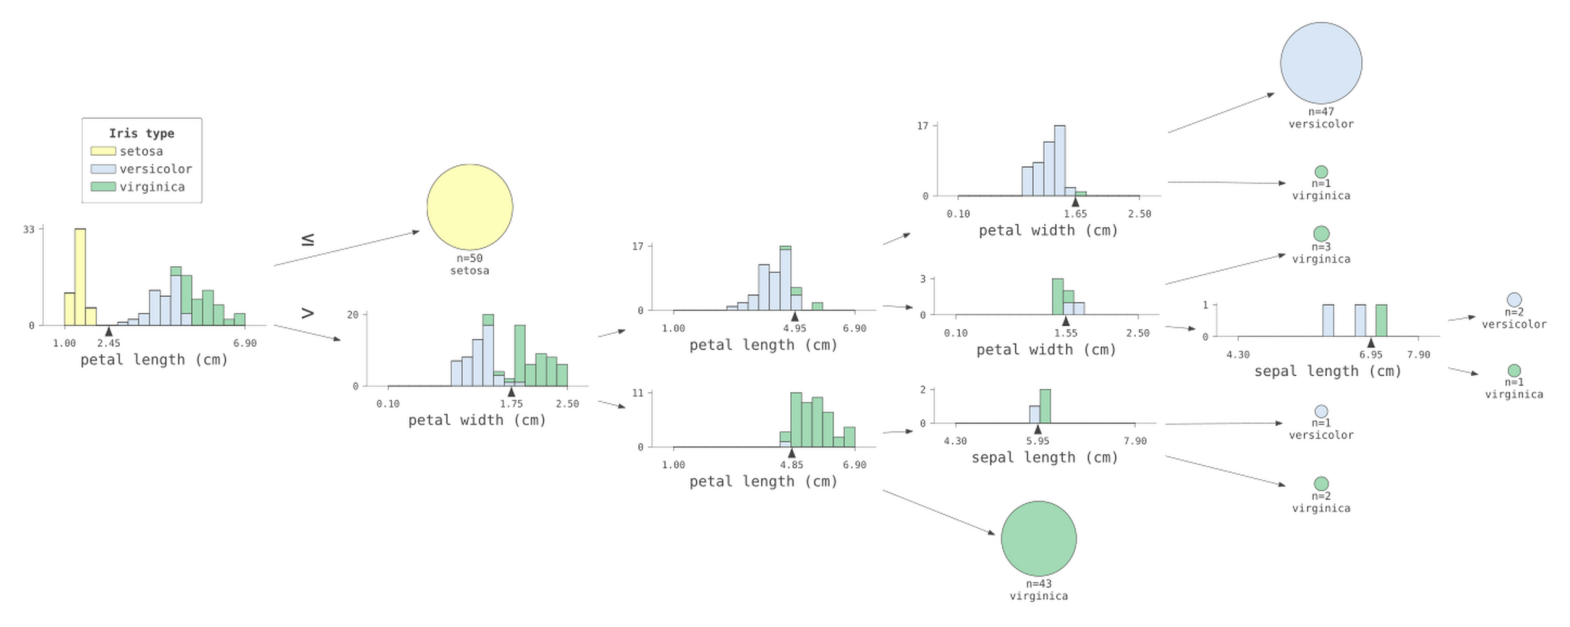

In [2]:
iris = load_iris()
X, y = iris.data, iris.target
clf = tree.DecisionTreeClassifier(random_state=123)
clf = clf.fit(X, y)

viz_model = dtreeviz.model(
    clf,
    X_train=X,
    y_train=y,
    feature_names=iris.feature_names,
    target_name="Iris type",
    class_names=iris.target_names,
)

display_dtreeviz(viz_model.view(orientation="LR", fontname="DejaVu Sans Mono", scale=1.5))

:::{note} 🌍 Iris data
:class: dropdown
:icon: false
We moeten de boomstructuur als volgt "lezen":
  
```python
if petal_length <= 2.45:
    return "Setosa"
else:
    if petal_width <= 1.75:
        if petal_length <= 4.95:
            if petal_width <= 1.65:
                return "Versicolor"
            else:
                return "Virginica"
        else:
            if petal_width <= 1.55:
                return "Virginica"
            else:
                if sepal_length <= 6.95:
                    return "Versicolor"
                else:
                    return "Virginica"
    else:
        if petal_length <= 4.85:
            if sepal_length <= 5.95:
                return "Versicolor"
            else:
                return "Virginica"
        else:
            return "Virginica"
:::

### Parameters
(target-decision-tree-parameters)=
**De volledige conditionele structuur, zoals hierboven geïllustreerd, vormt de parameters van het model. We weten met andere woorden niet op voorhand met hoeveel parameters we zullen eindigen - of hoe complex het model uiteindelijk zal zijn**. Dat heeft het voordeel dat we een heel flexibel model hebben, maar het nadeel dat we goed moeten opletten voor over-complexiteit en over-fitting. Er zijn wel verschillende hyper parameters zoals de maximum diepte van de vertakkingen, het minimum aantal voorbeelden in een vertakking, enz, maar dat verandert niets aan het feit dat we de model complexiteit niet rechtstreeks in de hand hebben.

### Features
(target-decision-tree-features)=
Decision tree modellen kunnen algemeen gesproken flexibel om met veel en heterogene features, wat een typische eigenschap is van gestructureerde data. Ze hebben ook een natuurlijke manier om belangrijke van minder belangrijke features te onderscheiden. Op iedere niveau worden alle features in overweging genomen, maar enkel de meest _informatieve_ wordt gebruikt. Daardoor komen minder informatieve features automatisch naar diepere vertakkingen geduwd en worden niet-informatieve features automatisch geweerd uit het model. Er is dus een **natuurlijke feature selectie**.

:::{note} 🌍 Iris data
:icon: false
:class: simple
Op basis van `Petal length` kunnen we met grote zekerheid de beslissing `Setosa` versus `{Versicolor, Virginica}` maken. Deze belangrijke feature komt dan ook bovenaan in de boomstructuur terecht.
:::
  
Doordat feature-schalen simpelweg opgedeeld worden binnen de boomstructuur, zijn _decision trees_ ook heel **geschikt om niet-lineaire verbanden** te herkennen - zonder dat er veel _feature engineering_ aan te pas moet komen.
  
Tenslotte kunnen _decision trees_ ook **vrij gemakkelijk omgaan met _missing values_**. De vaakst gebruikte strategie zijn _surrogate splits_. Hierbij wordt voor iedere vertakkingsconditie (bv. `petal_length <= 2.45`) een back-up regel of back-up regels voorzien.


### Leeralgoritme
(target-greedy-learning)=
Om de optimale vertakkingen te vinden wordt sequentieel gezocht naar de best mogelijke _split_ op een van de features. Er worden bij iedere stap volgens bepaalde (deels random) principes een reeks kandidaat _splits_ opgemaakt. Die kandidaten worden geëvalueerd met betrekking tot de kwaliteit van de predicties op het volgende niveau. Bij classificatie wordt die kwaliteit uitgedrukt in termen van de _zuiverheid_ zijn de predicties met betrekking tot de target categorieën. Bij regressie is het de bedoeling dat een _split_ tot kleinere predictiefouten (gekwadrateerde of absolute verschillen) op het volgende niveau leiden. Er is dus geen sprake van een algemene _loss_ functie, maar wel een lokale _loss_ functie op het niveau van individuele _splits_. Het leeralgoritme bij decision trees wordt daarom **greedy** genoemd: **er wordt bij iedere tussenstap een optimale keuze gemaakt, maar niet noodzakelijk op een globaal niveau**.  

### Taken
Naast **klassificatie** kunnen _decision trees_ ook voor **regressie** gebruikt worden

:::{note} 🌍 MPG
:icon: false
:class: simple
Om regressie met _decision trees_ te illustreren kijken we naar een dataset waarbij we het verbruik (_Miles Per Gallon_) trachten te voorspellen aan de hand van het aantal cilinders, cilinderinhoud en gewicht.
:::

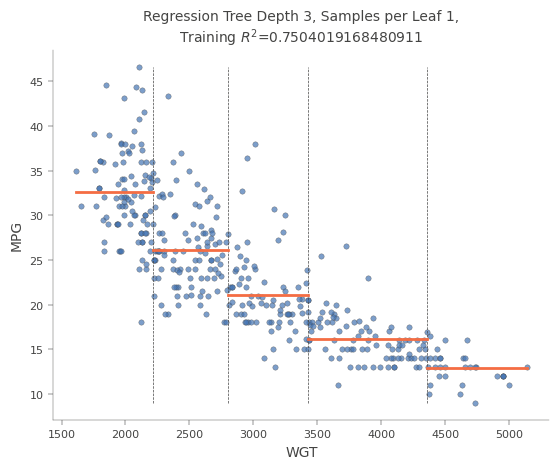

In [3]:
dataset_url = "https://raw.githubusercontent.com/parrt/dtreeviz/master/data/cars.csv"
df = pd.read_csv(dataset_url)
X = df.drop("MPG", axis=1)
y = df["MPG"]
features = list(X.columns)

reg = tree.DecisionTreeRegressor(max_depth=3, criterion="absolute_error")
reg.fit(X.values, y.values)

viz_rmodel = dtreeviz.model(reg, X, y, feature_names=features, target_name="MPG")

viz_rmodel.rtree_feature_space(features=["WGT"])

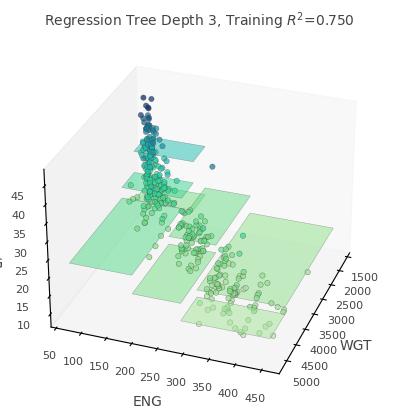

In [4]:
viz_rmodel.rtree_feature_space3D(
    features=["WGT", "ENG"],
    fontsize=10,
    elev=30,
    azim=20,
    show={"splits", "title"},
    colors={"tessellation_alpha": 0.5},
)

### Ervaring
Het gaat bij decision trees altijd over **supervised** learning.

### Evaluatie
Om de performantie van _decision trees_ te evalueren wordt in de eerste plaats gekeken naar de _scoring metrics_ die ook de training sturen (_Gini impurity/Entropy/Misclassification rate/MSE/MAR/R²/etc._).
**Omdat er een reëel gevaar bestaat voor _{ref}`over fitting <target-over-fitting>`_ wordt veel belang gehecht aan de performantie bij ongeziene test data**.

### Voordelen
- Interpreteerbaarheid: Iedere vertakking heeft een duidelijke betekenis
- Flexibiliteit (oa. ook geschikt voor multi-output problemen)
- Computationele efficiëntie omdat er geen globale optimalisatie gebeurt (_greedy_ optimisatie)

### Nadelen
- _Greedy_ optimalisatie geeft geen garantie op een globaal optimale boomstructuur
- Onstabiliteit: kleine aanpassingen aan de data kunnen een groot verschil geven in de boomstructuur
- Moeite met lineaire relaties: hoewel ze heel goed om kunnen met niet-lineariteit, moeten ze (te) veel splits maken om een niet-lineair verband te leren
- Moeite met extrapolatie: ze kunnen enkel splits en predicties maken in de range van de trainingsdata 
- **{ref}`Over fitting <target-over-fitting>`**: het aantal parameters kan ongecontroleerd groeien waardoor er _over fitting_ optreedt

## _Random Forests_
(target-random-forests)=
Het concept van _random forests_ is om **verschillende _decision trees_ (een _forest_) te trainen op verschillende subsets van de data en de output van de individuele modellen te aggregeren in een finale predictie**. Het behoort daarom tot de klasse van zogenoemde **_ensemble_ leeralgoritmes**. Algemeen gesproken, worden bij _ensemble_ technieken **predicties van verschillende modellen gecombineerd om tot een betere performantie te komen**.
  
(target-bootstrap-sampling)=
De naam _random forests_ verwijst ook naar het feit dat de methode gebaseerd is op _random bootstrap sampling_[^bootstrap]. Voor iedere nieuwe _decision tree_, wordt een nieuwe dataset gecreëerd door random samples te nemen uit de training data (mét teruglegging zodanig dat er telkens een even grote dataset wordt bekomen als bij de originele trainingsdata). Er wordt doorgaans ook een verschillende subset van de features gebruikt bij elke nieuwe _decision tree_.

### Voordelen
- Consistentie: Predicties zijn veel beter bestand tegen kleine aanpassingen in de data
- Bestand tegen _overfitting_
- Ingebouwde _missing value_ handling
- Krachtige _off-the-shelve_ oplossing voor veel complexe predictieproblemen
- Parallellisatie: verschillende _decision trees_ kunnen onafhankelijk van elkaar getraind worden (zie bv. [SparkMLlib](https://spark.apache.org/docs/latest/ml-guide.html))

### Nadelen
- Verlies van interpreteerbaarheid
- Trage _inference_: alle individuele trees moeten eerst een predictie maken.
- Grote opslag/geheugen nodig
- Trage training
- Complexere hyper parameter tuning

[^bootstrap]: _Bootstrapping_ is een algemenere statistische techniek om de _distributie_ van schatters, zoals het gemiddelde, via sampling (meestal met teruglegging) te _empirisch_ bepalen.

In [5]:
from sklearn import ensemble

X, y = iris.data, iris.target
clf = ensemble.RandomForestClassifier(
    n_estimators=50,  # Number of trees in the forest
    max_depth=5,  # Maximum depth of the trees
    random_state=42,  # Seed for reproducibility
)
clf = clf.fit(X, y)

In [6]:
clf.estimators_[:10]

[DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1608637542),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1273642419),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1935803228),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt', random_state=787846414),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt', random_state=996406378),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1201263687),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt', random_state=423734972),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt', random_state=415968276),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt', random_state=670094950),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1914837113)]

## _Gradient Boosted trees_
(target-boosting)=
**_Boosting_ is een algemene _ensemble_-techniek waarbij de modellen in het _ensemble_ niet onafhankelijk van elkaar (in parallel) gebouwd worden, maar sequentieel. Elk nieuw model in de reeks wordt getraind om de fouten van het voorafgaande model te corrigeren**. Dit iteratieve proces stelt het globale ensemble-model in staat om zijn nauwkeurigheid te verbeteren door te focussen op moeilijk te voorspellen voorbeelden. Er bestaan verschillende varianten, maar _Gradient Boosting_ levert tegenwoordig vaak de beste resultaten op. Bij deze techniek starten we met een eenvoudig initieel model (bv. het gemiddelde van de target bij regressie). Dan wordt iteratief telkens in 3 stappen gewerkt:  
1. De {ref}`gradiënt <target-sse-gradient>` van de _loss_ functie wordt berekend naar iedere input. Bij een regressieprobleem met een $L^2$ _loss_ komt dit neer op de negatieve _residuals_: $-2(y_i-f(x_i))$.
2. Die gradiënt vormt de _target_ voor een volgend nieuw model.
3. De predicties van het nieuwe model worden bij de predicties in de vorige stap geteld (gewogen met een _learning rate_ hyper parameter).
Op deze manier worden de predictiefouten stelselmatig kleiner en kleiner.

### Voordelen
- Accuraatheid: _Gradient Boosting_ is algemeen gesproken één van de meest accurate algoritmes voor (semi-)gestructureerde data. Het doet het vaak beter dan _random forests_ omdat bij die laatste, onafhankelijke _decision trees_ worden getraind. Iedere individuele _tree_ is dan onderhevig aan dezelfde predictiefouten, terwijl bij _gradient boosting_ iedere _tree_ leert uit de fouten van de voorgaande _trees_.
- Gebalanceerd leren: _Trees_ richten zich op de moeilijk te voorspellen gevallen. Wanneer dit samenhangt met _imbalances_ in de data, resulteert dit in een natuurlijke beveiliging tegen _bias_.
- Flexibiliteit: Kan met eender welke _loss_ functie werken zolang die differentieerbaar is.
- Efficiënt: Resulteert vaak in kleinere ensembles


In [7]:
from xgboost import XGBClassifier

clf = XGBClassifier()
clf = clf.fit(X, y)

print(f"\nNumber of boosted rounds: {clf.get_booster().num_boosted_rounds()}")
print(f"Number of features: {clf.n_features_in_}")
print(f"Classes: {clf.classes_}")

print("\nFeature importance (gain):")
importance_dict = clf.get_booster().get_score(importance_type="gain")
for feature, importance in sorted(importance_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"  {feature}: {importance:.4f}")


Number of boosted rounds: 100
Number of features: 4
Classes: [0 1 2]

Feature importance (gain):
  f2: 2.9918
  f3: 1.3149
  f1: 0.0727
  f0: 0.0424
